In [7]:
import os
import sys

# Ensure src is in the path if running from the examples directory without installing the package
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(os.path.join(project_root, "src"))

from artefactual.scoring.entropy_methods.epr import EPR  # noqa: E402
from artefactual.scoring.entropy_methods.wepr import WEPR  # noqa: E402

## 1. Simulate Inference Responses (10 Samples)

We generate 10 mock responses:
- 5 **Easy/Certain** cases (low entropy).
- 5 **Hallucination** cases (high entropy).
We shuffle them to simulate a batch of mixed queries.


In [8]:
import random


def create_mock_response(id_suffix, text, is_hallucination):
    # Create a few tokens
    tokens = []
    for token_text in text.split():
        if is_hallucination:
            # Flat distribution (uncertain)
            # Top token has low prob, others are close
            logprob = -2.5 + random.uniform(-0.2, 0.2)  # noqa: S311
            # Others are close
            other1 = logprob - random.uniform(0.1, 0.5)  # noqa: S311
            other2 = logprob - random.uniform(0.1, 0.5)  # noqa: S311
        else:
            # Peaked distribution (certain)
            # Top token has high prob (near 0 logprob)
            logprob = -0.001 - random.uniform(0.0, 0.01)  # noqa: S311
            # Others are far away
            other1 = logprob - random.uniform(5.0, 8.0)  # noqa: S311
            other2 = logprob - random.uniform(5.0, 8.0)  # noqa: S311

        token_data = {
            "token": token_text,
            "logprob": logprob,
            "top_logprobs": [
                {"token": token_text, "logprob": logprob},
                {"token": "other", "logprob": other1},
                {"token": "another", "logprob": other2},
            ],
        }
        tokens.append(token_data)

    return {
        "id": f"resp_{id_suffix}",
        "object": "response",
        "created": 1234567890,
        "model": "ministral-simulation",
        "output": [{"index": 0, "content": [{"type": "text", "text": text, "logprobs": tokens}]}],
        "is_hallucination": is_hallucination,  # Metadata for our tracking
    }


# Generate 10 samples (5 easy, 5 hallucinations)
samples = []

# 5 Easy
easy_texts = ["Paris", "Water", "Sun", "Blue", "Dog"]
for i, text in enumerate(easy_texts):
    samples.append(create_mock_response(f"easy_{i}", text, is_hallucination=False))

# 5 Hallucinations
hallu_texts = ["Zorgon", "Xyloph", "Quibble", "Flibber", "Glorp"]
for i, text in enumerate(hallu_texts):
    samples.append(create_mock_response(f"hallu_{i}", text, is_hallucination=True))

# Shuffle them
random.seed(42)
random.shuffle(samples)

## 2. Initialize WEPR with Custom Weights

We initialize the `WEPR` class by pointing it to the specific weights file for the Ministral model.

In [9]:
# Define path to the weights file
# Assuming the notebook is in 'examples/' and the file is in 'src/artefactual/data/'
weights_path = os.path.join(project_root, "src/artefactual/data/weights_ministral.json")

# Check if file exists
if not os.path.exists(weights_path):
    msg = f"Weights file not found at: {weights_path}"
    raise FileNotFoundError(msg)

# Initialize WEPR
# The 'model' argument can be a path to a JSON file containing the weights
wepr = WEPR(model=weights_path)
epr = EPR(model=os.path.join(project_root, "src/artefactual/data/calibration_ministral.json"))

/tmp/ipykernel_2613259/2641677921.py:13: UserWarning: Could not load calibration for model '/home/gjeannin/artefactual/src/artefactual/data/calibration_Ministral.json'. Proceeding with uncalibrated scores.
  epr = EPR(model=os.path.join(project_root, "src/artefactual/data/calibration_Ministral.json"))


## 3. Compute Scores for All Samples

We compute WEPR and EPR scores for all 10 samples.


In [10]:
results = []


for sample in samples:
    wepr_score = wepr.compute(sample)[0]
    epr_score = epr.compute(sample)[0]

    is_hallu = sample["is_hallucination"]

    results.append({
        "id": sample["id"],
        "text": sample["output"][0]["content"][0]["text"],
        "is_hallucination": is_hallu,
        "wepr": wepr_score,
        "epr": epr_score,
    })

## 4. Visualization

We plot the WEPR scores. The threshold is 0.5:
- **Score > 0.5**: Predicted Hallucination
- **Score < 0.5**: Predicted Safe


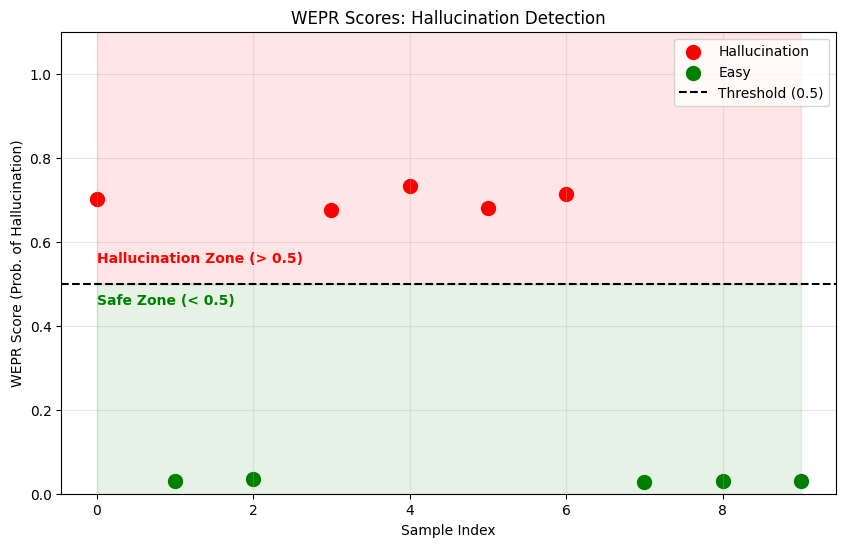

In [12]:
import matplotlib.pyplot as plt

# Extract data for plotting
ids = range(len(results))
wepr_scores = [r["wepr"] for r in results]
labels = ["Hallucination" if r["is_hallucination"] else "Easy" for r in results]
colors = ["red" if r["is_hallucination"] else "green" for r in results]

plt.figure(figsize=(10, 6))

# Plot points
# We loop to handle legend labels correctly (avoid duplicates)
seen_labels = set()
for i, (x, y, color, label) in enumerate(zip(ids, wepr_scores, colors, labels, strict=True)):  # noqa: B007
    if label not in seen_labels:
        plt.scatter(x, y, c=color, s=100, label=label)
        seen_labels.add(label)
    else:
        plt.scatter(x, y, c=color, s=100)

# Add threshold line
plt.axhline(y=0.5, color="black", linestyle="--", label="Threshold (0.5)")

# Add zones
plt.fill_between(ids, 0.5, 1.1, color="red", alpha=0.1)
plt.fill_between(ids, -0.1, 0.5, color="green", alpha=0.1)

plt.text(0, 0.55, "Hallucination Zone (> 0.5)", color="red", fontweight="bold")
plt.text(0, 0.45, "Safe Zone (< 0.5)", color="green", fontweight="bold")

plt.title("WEPR Scores: Hallucination Detection")
plt.ylabel("WEPR Score (Prob. of Hallucination)")
plt.xlabel("Sample Index")
plt.ylim(0, 1.1)
plt.legend(loc="upper right")
plt.grid(alpha=0.3)

plt.show()